# EdU+ nuclei Analysis

From the previous segmentation, the median fluorescence intensity value (and other estimators) for each nuclei was included. We want to be able to distinguish between positively stained nuclei from negative ones and then relate them to their size. With this information, we would like to see:

1. Are EdU+ nuclei always bigger?



## Load dependencies and datasets

We will begin by loading the necessary dependencies, stating the path to the dataset and loading it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns

from nuclei_segmenter.loader import get_nuclei_size_df
from nuclei_segmenter.quantify import find_edu_nuclei_in_df
from nuclei_segmenter.vis import get_contours, labeled_colormap, my_positive_colormap, my_negative_colormap

In [2]:
DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining IGF1 Exp')
BIG_DATA_DIR = pathlib.Path(r'C:\Users\agucor\Karolinska Institutet\Afshan Iqbal - EdU staining IGF1 Exp\sparse nuclei')

In [3]:
nuclei_size_original = get_nuclei_size_df(DATA_DIR)
nuclei_size_big = get_nuclei_size_df(BIG_DATA_DIR)
nuclei_size = pd.concat([nuclei_size_original, nuclei_size_big], ignore_index=True)
nuclei_size

,area_2D,eccentricity,equivalent_diameter_area,intensity_mean_2D,label,z,area_3D,intensity_mean_3D,intensity_mean_edu,intensity_median,area,volume,sample_name,condition,cell_line,region,sample_number,igf1
0,134,0.694508,13.061933,50071.798507,59,4,346,31987.965318,303.234104,301.0,54.444321,1405.801117,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
1,100,0.563438,11.283792,48793.960000,63,4,185,32735.221622,292.643243,280.0,40.630090,751.656666,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
2,169,0.805656,14.668929,11530.520710,64,3,169,11530.520710,326.071006,312.0,68.664852,686.648522,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
3,229,0.491526,17.075475,50432.737991,65,4,599,32087.337229,21779.205342,23463.0,93.042906,2433.742396,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
4,171,0.588731,14.755472,54342.304094,66,4,513,35846.684211,490.385965,299.0,69.477454,2084.323621,Ndr1219 hilar ctrl -1,Ndr,1219,Hilar,1,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187526,207,0.767882,16.234549,10168.420290,436,0,207,10168.420290,105.169082,82.0,26.868855,214.950842,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control
187527,85,0.542482,10.403142,14924.211765,437,0,85,14924.211765,286.847059,164.0,11.033105,88.264838,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control
187528,274,0.657265,18.677999,15847.233577,440,0,274,15847.233577,92.861314,77.5,35.565538,284.524303,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control
187529,367,0.835926,21.616635,2475.482289,445,0,367,2475.482289,113.245232,83.0,47.637052,381.096420,Wt1225 hilar ctrl-9,WT,1225,Hilar,9,Control


## Find EdU nuclei

Find EdU nuclei takes a DataFrame and groups by images to find a threshold which will be used to classify between EdU positive and negative nuclei.

In [4]:
nuclei_size = find_edu_nuclei_in_df(nuclei_size, intensity_col='intensity_mean_edu')

## Load and show EdU detection examples

To assess if the EdU classification is working correctly, we should plot the contours of each nuclei according to EdU positivity. It would be nice to add a plot of the image with all the nuclei and maybe their size.

In [5]:
from nuclei_segmenter.loader import get_file, get_image, get_edu_image, get_labeled

def get_images(filepath):
    file = get_file(filepath)
    img = get_image(file)
    edu = get_edu_image(file)

    prop_df = pd.read_excel(DATA_DIR / 'nuclei_size.xlsx', sheet_name=filepath.stem)
    good_planes = prop_df.z.unique()
    if len(good_planes) == 0:
        return None, None
    return img[good_planes], edu[good_planes]

In [6]:
IMG_DIR = DATA_DIR / 'data'
SEG_DIR = DATA_DIR / 'segmented'

files = [filepath.relative_to(SEG_DIR) for filepath in SEG_DIR.rglob('*.tiff')]

In [7]:
this_filepath = files[1]
this_df = nuclei_size.query(f'sample_name == "{this_filepath.stem}"')

In [8]:
from nuclei_segmenter.vis import relabel

img, edu = get_images(IMG_DIR / files[1].with_suffix('.czi'))
labeled = get_labeled(SEG_DIR / files[1])

all_labels = np.arange(np.max(labeled))
present_labels = [label if label in this_df.label.values else 0 for label in all_labels]
edu_pos_labeled = relabel(labeled, zip(this_df.edu.values + 1, this_df.label.values))
labeled = relabel(labeled, zip(present_labels, all_labels))

In [9]:
def plot_edu_classification(img, edu, edu_pos_labeled):
    fig, axs = plt.subplots(2, 2, figsize=(17, 17))

    axs[0, 0].imshow(np.max(img, axis=0))

    axs[0, 1].imshow(np.max(edu, axis=0))

    axs[0, 0].axis('off')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(np.max(img, axis=0))

    contours = get_contours(np.max(labeled, axis=0))
    axs[1, 0].imshow(contours, cmap=labeled_colormap, vmin=0.1, interpolation='none')

    axs[1, 1].imshow(np.max(edu, axis=0))

    contours_positive = get_contours(np.max(edu_pos_labeled == 2, axis=0).astype(int))
    axs[1, 1].imshow(contours_positive, cmap=my_positive_colormap, vmin=0.1, interpolation='none')

    contours_negative = get_contours(np.max(edu_pos_labeled == 1, axis=0).astype(int))
    axs[1, 1].imshow(contours_negative, cmap=my_negative_colormap, vmin=0.1, interpolation='none')

    axs[1, 0].axis('off')
    axs[1, 1].axis('off')

    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    return axs

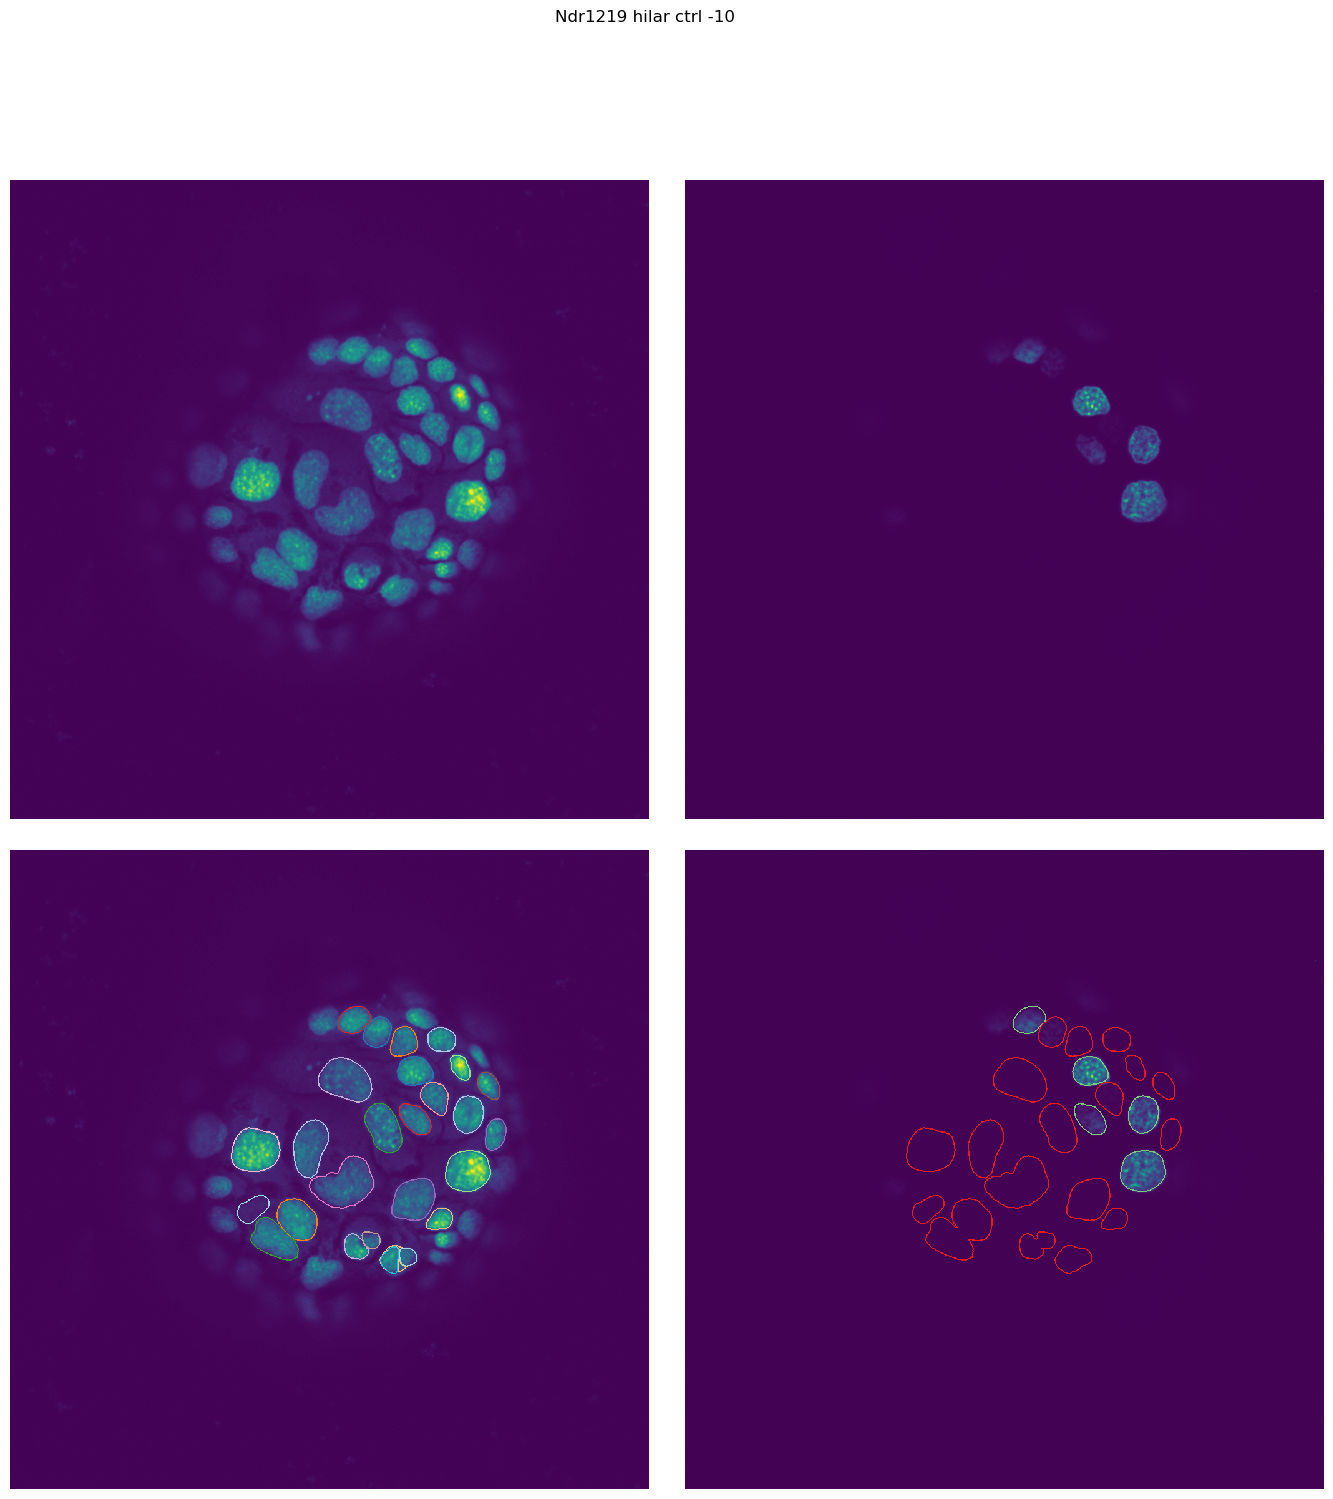

In [10]:
plot_edu_classification(img, edu, edu_pos_labeled)
plt.suptitle(this_filepath.stem)
plt.show()

# EdU+ nuclei

After assessing that the algorithm distinguishes between positive and negative nuclei, we can look into:

1. If we have more EdU+ nuclei in some particular conditions;

2. How different EdU+ nuclei are in size.

## How many EdU+ nuclei are there in each condition?

Are there more EdU+ nuclei in some region or condition?

Does IGF1 treatment increse the number of EdU+ nuclei?

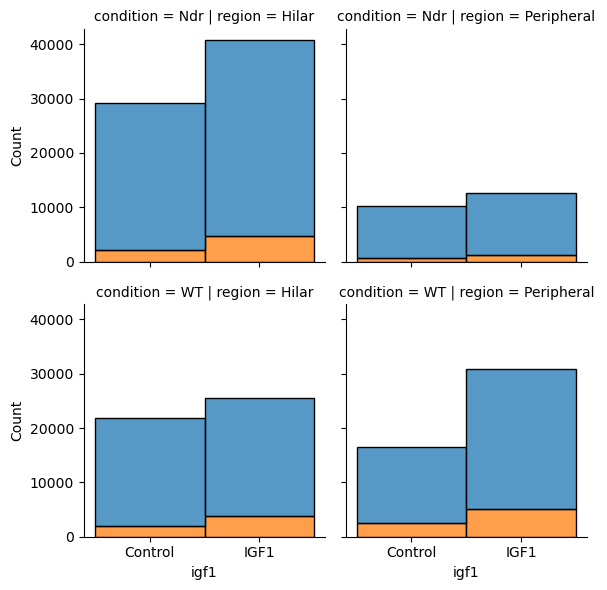

In [11]:
g = sns.FacetGrid(data=nuclei_size, col='region', row='condition')
g.map_dataframe(sns.histplot, x="igf1", hue='edu', stat='count', multiple='stack')
g.add_legend()
plt.show()

IGF1 treatment seems to increase the number of cells as well as the number of EdU+ cells.

*Note*: There are less Ndr Peripheral nuclei than in other conditions.

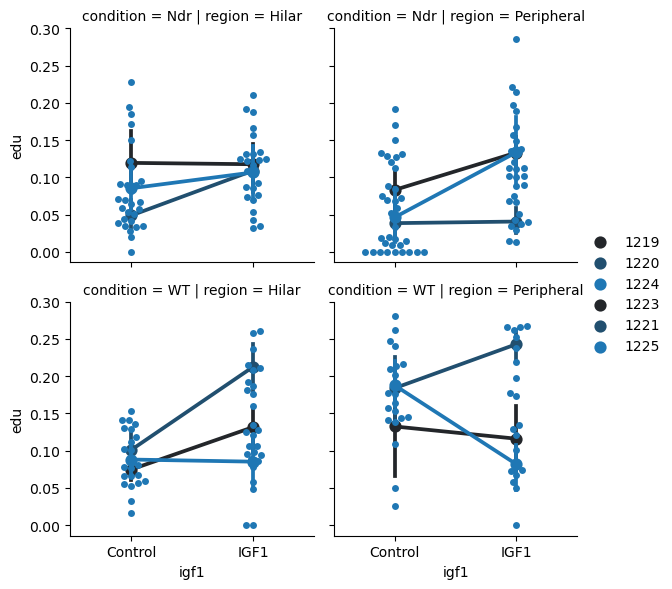

In [12]:
ratio_df = nuclei_size.groupby('sample_name').agg({'edu': lambda s: sum(s)/len(s), 'cell_line': 'first', 'region': 'first', 'condition': 'first', 'igf1': 'first'})
g = sns.FacetGrid(data=ratio_df, col='region', row='condition')
g.map_dataframe(sns.swarmplot, y="edu", x='igf1')
g.map_dataframe(sns.pointplot, y="edu", x='igf1', hue='cell_line')
g.add_legend()
plt.show()

In [13]:
from scipy.stats import mannwhitneyu

for conds, this_df in ratio_df.groupby(['region', 'condition']):
    test_result = mannwhitneyu(this_df.query('igf1 == "Control"').edu.values, this_df.query('igf1 == "IGF1"').edu.values)
    print(f"p-value for Mann-Whitney U test in {conds} of Control organoids vs IGF1 treated is {test_result.pvalue:.4f}")

for conds, this_df in ratio_df.query('igf1 == "Control"').groupby('region'):
    test_result = mannwhitneyu(this_df.query('condition == "WT"').edu.values, this_df.query('condition == "Ndr"').edu.values)
    print(f"p-value for Mann-Whitney U test in {conds} region of Control organoids is {test_result.pvalue:.4f}")

p-value for Mann-Whitney U test in ('Hilar', 'Ndr') of Control organoids vs IGF1 treated is 0.0187
p-value for Mann-Whitney U test in ('Hilar', 'WT') of Control organoids vs IGF1 treated is 0.0167
p-value for Mann-Whitney U test in ('Peripheral', 'Ndr') of Control organoids vs IGF1 treated is 0.0014
p-value for Mann-Whitney U test in ('Peripheral', 'WT') of Control organoids vs IGF1 treated is 0.4732
p-value for Mann-Whitney U test in Hilar region of Control organoids is 0.2533
p-value for Mann-Whitney U test in Peripheral region of Control organoids is 0.0000


There is a statistical difference in the number of EdU+ nuclei between IGF1 treated and Control organoids.

If we compare number of EdU+ nuclei region-wise in Control organoids, we see no statistical difference in the Hilar region. There seems to be more EdU+ nuclei in WT than in Ndr in Peripherla region.

## EdU+ nuclei sizes

Let's take a look at nuclei sizes in different conditions.

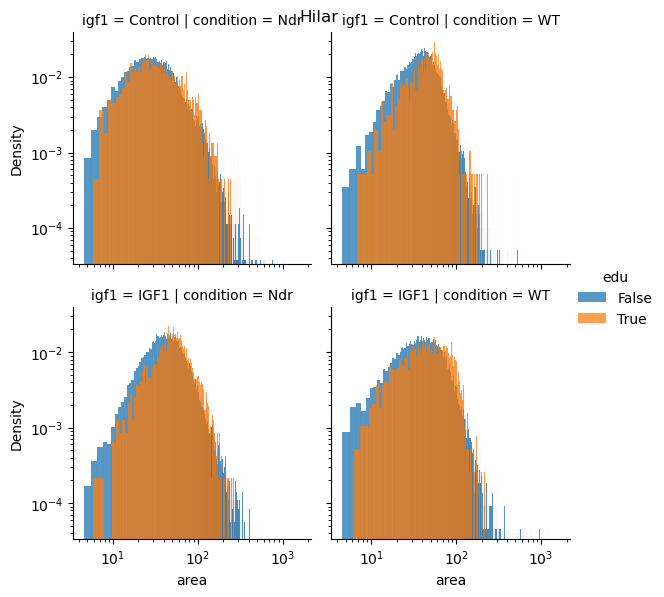

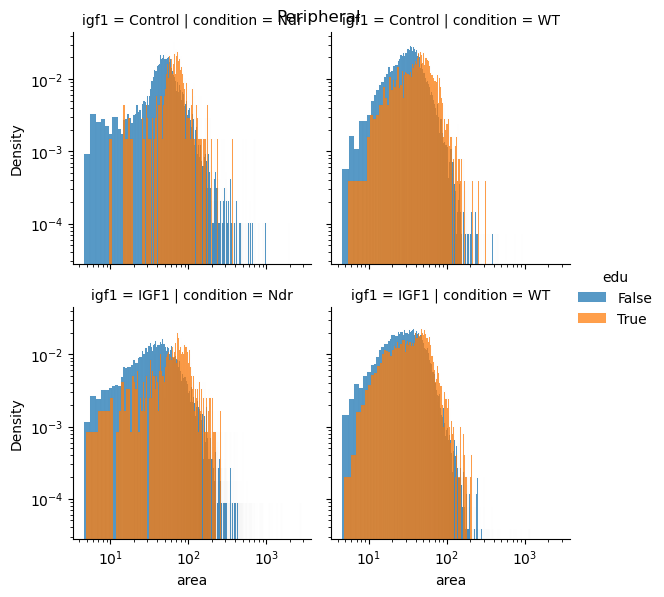

In [14]:
for region, this_df in nuclei_size.groupby('region'):
    g = sns.FacetGrid(data=this_df, col='condition', row='igf1', hue='edu')
    g.map_dataframe(sns.histplot, x="area", stat='density', discrete=True, common_norm=False)
    g.add_legend()
    plt.semilogx()
    plt.semilogy()
    plt.suptitle(region)
    plt.subplots_adjust()
    plt.show()

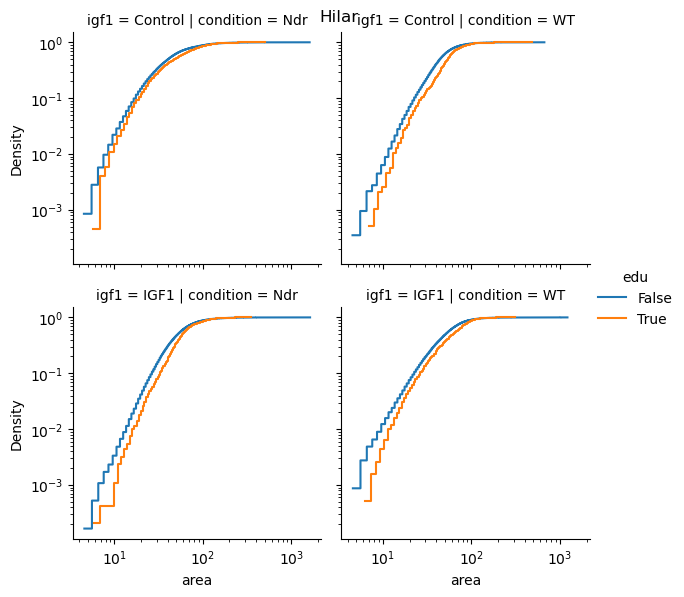

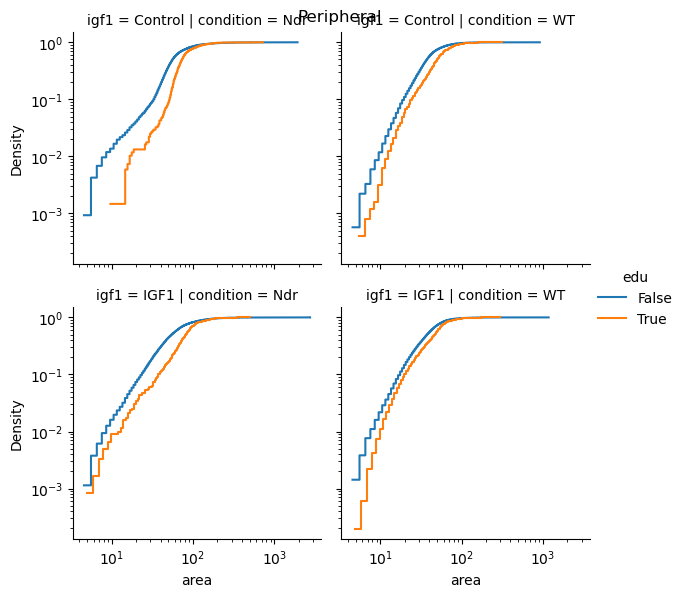

In [15]:
for region, this_df in nuclei_size.groupby('region'):
    g = sns.FacetGrid(data=this_df, col='condition', row='igf1', hue='edu')
    g.map_dataframe(sns.histplot, x="area", discrete=True, cumulative=True, fill=False, element='step', stat='density', common_norm=False)
    g.add_legend()
    plt.semilogx()
    plt.semilogy()
    plt.suptitle(region)
    plt.subplots_adjust()
    plt.show()

EdU+ nuclei tendo to be a bigger than EdU- ones.

The remaining questions is whether we find big nuclei in the EdU+ population.

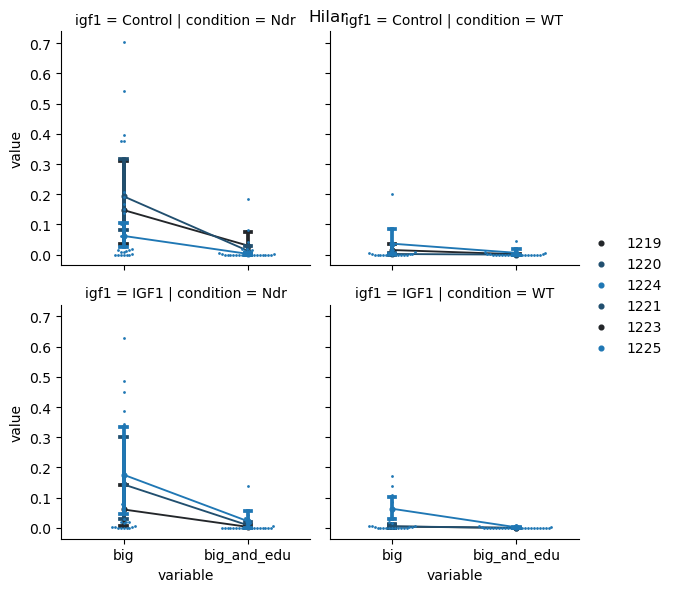

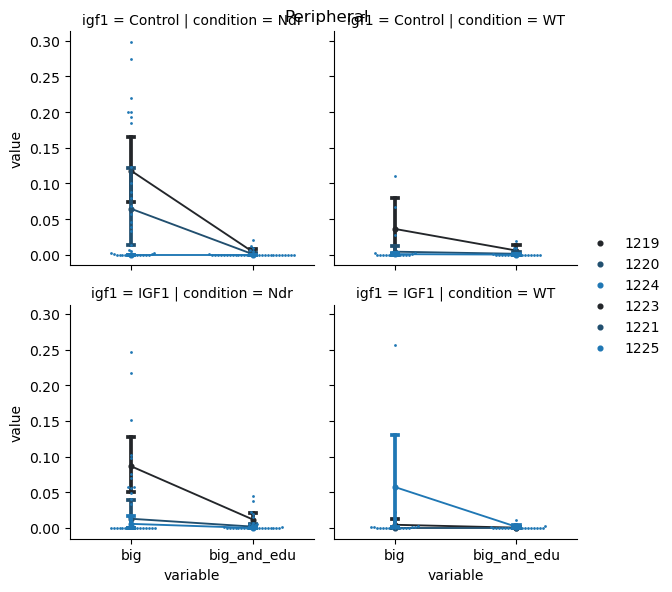

In [16]:
nuclei_size['big'] = nuclei_size.area.values > 201
nuclei_size['big_and_edu'] = np.logical_and(nuclei_size['big'].values, nuclei_size['edu'].values)
big_df = nuclei_size.groupby('sample_name').agg({'big': lambda x: sum(x)/len(x), 
                                                 'edu': lambda x: sum(x)/len(x), 
                                                 'big_and_edu': lambda x: sum(x)/len(x), 
                                                 'condition': 'first', 
                                                 'region': 'first', 
                                                 'cell_line': 'first', 
                                                 'igf1':'first'})

for region, this_df in big_df.groupby('region'):
    g = sns.FacetGrid(data=this_df.reset_index(drop=False).melt(
        id_vars=['sample_name', 'condition', 'igf1', 'cell_line'], value_vars=['big', 'big_and_edu']),
          col='condition', row='igf1')
    g.map_dataframe(sns.pointplot, x="variable", y='value', hue='cell_line', capsize=.05, scale=0.5)
    g.map_dataframe(sns.swarmplot, x="variable", y='value', size=2)
    g.add_legend()
    plt.suptitle(region)
    plt.ylabel('Percentage of nuclei per organoid')
    plt.subplots_adjust()
    plt.show()

In [17]:
for conds, this_df in big_df.groupby(['region', 'condition', 'igf1']):
    test_result = mannwhitneyu(this_df.big.values, 
                               this_df.big_and_edu.values, 
                               alternative='greater')
    print(f"p-value for Mann-Whitney U one-sided test in {conds} of percentage of big nuclei is greater than big and being EdU+ is {test_result.pvalue:.4f}")

p-value for Mann-Whitney U one-sided test in ('Hilar', 'Ndr', 'Control') of percentage of big nuclei is greater than big and being EdU+ is 0.0001
p-value for Mann-Whitney U one-sided test in ('Hilar', 'Ndr', 'IGF1') of percentage of big nuclei is greater than big and being EdU+ is 0.0000
p-value for Mann-Whitney U one-sided test in ('Hilar', 'WT', 'Control') of percentage of big nuclei is greater than big and being EdU+ is 0.0236
p-value for Mann-Whitney U one-sided test in ('Hilar', 'WT', 'IGF1') of percentage of big nuclei is greater than big and being EdU+ is 0.0003
p-value for Mann-Whitney U one-sided test in ('Peripheral', 'Ndr', 'Control') of percentage of big nuclei is greater than big and being EdU+ is 0.0000
p-value for Mann-Whitney U one-sided test in ('Peripheral', 'Ndr', 'IGF1') of percentage of big nuclei is greater than big and being EdU+ is 0.0270
p-value for Mann-Whitney U one-sided test in ('Peripheral', 'WT', 'Control') of percentage of big nuclei is greater than big 

In general, big and EdU+ population is different from the only big nuclei population. Although this is expected, as we are adding an extra condition, it is not always the case. In WT peripheral control organoids, we can not reject the hypothesis that these distributions are different. We can reject these hypothesis with 95% confidence in Ndr Peripheral IGF1 treated and WT Hilar control organoids and more than 99% confidence in the remaining cases.